In [93]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from nltk.tokenize import word_tokenize,sent_tokenize
import gensim.downloader as api
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import contractions
import unidecode

In [5]:
#reomve pattern function, input_text is the text we want to process, the pattern is the pattern we want to remove
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

In [6]:
emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

In [135]:
#preprocess the data
replacers = {'dm': 'direct message',
 'thx': 'thanks',
 'dming': 'direct messaging',
 'dmed': 'direct messaged',
 'plz': 'please',
 'u': 'you',
 'asap': 'as soon as possible',
 '...': '',
 '. . .': '',
 'r': 'are', 
 'tho': 'though', 'wassup' : 'whats up', 'lol': 'laughing out loud', 'layin': 'laying', 'y' :'why', 'bd' : 'birthday',
  'btw': 'by the way', 'ty': 'thank you', 'brb': 'be right back'}
def preprocess(df):
    
    #remove the @
    df['processed'] = np.vectorize(remove_pattern)(df['content'], "@[\w]*")
    
    #convert to lower case
    df.loc[:, 'processed'] = df.loc[:, 'processed'].str.lower()
    
    #remove any links
    df['processed'] = df['processed'].str.replace('http[^\s]*',"")
    
    
    #remove the #
    df['processed'] = np.vectorize(remove_pattern)(df['processed'], "#")
    
    #converting don't -> do not
    removed = []
    for text in df['processed']:
        txt =[]
        for word in text.split():
            txt.append(contractions.fix(word))
        ex_txt = ' '.join(txt)
        removed.append(ex_txt)
    df.drop('processed', axis = 1, inplace = True)
    df['processed'] = removed
    
    # converting unicode to ascii
    stemmer = PorterStemmer()
    removed = []
    for text in df['processed']:
        removed.append(unidecode.unidecode(text))
    df.drop('processed', axis = 1, inplace = True)
    df['processed'] = removed
    
    #remove emoji
    df['processed'] = np.vectorize(remove_pattern)(df['processed'], emoji)
    
    #remove the special characters, numbers, punctuations
    df['processed'] = df['processed'].str.replace("[^a-zA-Z#]", " ",regex=True)
    
    #converting common acronyms to common words
    df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))
    
     #remove the words smaller than 2
    df['processed'] = df['processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    
    #remove white spaces
    df['processed'] = df['processed'].str.strip()
    
    return df

In [230]:
df = pd.read_csv('https://query.data.world/s/5xzuftmozqteqbqzopbcgxbjzusyi7')

In [231]:
#Giving labels to the emotion
labels = {'love':6, 'surprise':4, 'relief':7, 'boredom':3, 'neutral':1, 'worry': 5, 'happiness': 0, 'sadness': 2, 'anger':8, 'hate': 9, 'empty': 10, 'enthusiasm': 12, 'fun': 11}

In [232]:
#converting our  above emotions to the labels and dropping the content
df['sentiment'] = df['sentiment'].replace(labels)
#df['content']= list(map(lambda x: x.lower(), df['processed']))
df.drop(index=df[df['sentiment'] == 6].index, inplace=True)
df.drop(index=df[df['sentiment'] == 4].index, inplace=True)
df.drop(index=df[df['sentiment'] == 7].index, inplace=True)
df.drop(index=df[df['sentiment'] == 3].index, inplace=True)
df.drop(index=df[df['sentiment'] == 5].index, inplace=True)
df.drop(index=df[df['sentiment'] == 8].index, inplace=True)
df.drop(index=df[df['sentiment'] == 9].index, inplace=True)
df.drop(index=df[df['sentiment'] == 10].index, inplace=True)
df.drop(index=df[df['sentiment'] == 11].index, inplace=True)
df.drop(index=df[df['sentiment'] == 12].index, inplace=True)
df

,tweet_id,sentiment,author,content
1,1956967666,2,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,2,coolfunky,Funeral ceremony...gloomy friday...
4,1956968416,1,xkilljoyx,@dannycastillo We want to trade with someone w...
6,1956968487,2,ShansBee,"I should be sleep, but im not! thinking about ..."
8,1956969035,2,nic0lepaula,@charviray Charlene my love. I miss you
...,...,...,...,...
39992,1753918881,1,_Alectrona_,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,1,bushidosan,"@sendsome2me haha, yeah. Twitter has many uses..."
39994,1753918900,0,courtside101,Succesfully following Tayla!!
39995,1753918954,1,showMe_Heaven,@JohnLloydTaylor


In [233]:
df_x = df
df_y = df['sentiment']
df_x

,tweet_id,sentiment,author,content
1,1956967666,2,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,2,coolfunky,Funeral ceremony...gloomy friday...
4,1956968416,1,xkilljoyx,@dannycastillo We want to trade with someone w...
6,1956968487,2,ShansBee,"I should be sleep, but im not! thinking about ..."
8,1956969035,2,nic0lepaula,@charviray Charlene my love. I miss you
...,...,...,...,...
39992,1753918881,1,_Alectrona_,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,1,bushidosan,"@sendsome2me haha, yeah. Twitter has many uses..."
39994,1753918900,0,courtside101,Succesfully following Tayla!!
39995,1753918954,1,showMe_Heaven,@JohnLloydTaylor


In [234]:
x_train, x_rem, y_train, y_rem = train_test_split(df_x, df_y, test_size=0.5)
x_test_t, x_valid_t, y_test, y_valid = train_test_split(x_rem, y_rem, test_size=0.5)
df_processed_x = preprocess(x_train)
#convert the labels into categroical data using the keras library
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)
#The output of the y_train and y_test will be a binary matrix and has columns equal to the number of categories in the data.
df_processed_x

C:\Users\mangu\AppData\Local\Temp\ipykernel_9540\2613350570.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_9540\2613350570.py:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


,tweet_id,sentiment,author,content,processed
18762,1966071403,2,aircrash,I heard an icecream truck and took of like a s...,heard icecream truck and took like shot but co...
19784,1966351638,2,em_miml,misses home on the farm,misses home the farm
18337,1965942344,2,julietsroom,tried to swat a fly with my Buddhist magazine....,tried swat fly with buddhist magazine bad karma
33688,1752674242,0,HDecaf,probably one of the best surprises ever...you ...,probably one the best surprises ever you reall...
17467,1965670049,1,AlyceMadden,im slightly over it dont feel like today much ...,slightly over not feel like today much all
...,...,...,...,...,...
31420,1751952700,1,Peasinapod,@flybabymoni Well the one thing where you lay ...,well the one thing where you lay the floor cou...
1011,1957195455,0,seniahh,so carlie came over and she fell asleep on me,carlie came over and she fell asleep
28229,1696133620,0,SGajewski,"@infovestment LOL, very true. I've been keepin...",laughing out loud very true have been keeping ...
27681,1695884011,0,Foxxy77,"@Isapersefone D Well, if you got that DVD then...",well you got that dvd then you should get thos...


In [157]:
df_processed_x
x_train = df_processed_x['processed']
x_test = x_test_t['content']
x_valid = x_valid_t['content']

30403                                           pic please
15750    time for bed got some learning tomorrow with e...
9645     have ever told you absolutly hate writing emai...
20963    loved this any more would streak thru the hood...
7028     kerry threw ball anand bounced off his head la...
                               ...                        
19276                     yes its the twins wontt watching
27037    thanks for trying was hoping bud trillin but t...
17042                                how lose guy ten days
30242    ftsk and mercy mercedes were amazing tonight a...
33725                                  chillin with kealie
Name: processed, Length: 9506, dtype: object

In [229]:
df_processed_x['content'].iloc[[190]]

21167    @zem42 I cannot tell a lie. I did.
Name: content, dtype: object

In [158]:
x_train.shape

(9506,)

In [159]:
x_test.shape

(4753,)

In [160]:
x_valid.shape

(4753,)

In [161]:
#Now we have to tokenize the data 
#we are using Keras library here
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [189]:
tokenizer = Tokenizer(5000,lower=True)
combi = pd.concat([x_train, x_test], axis = 0)
tokenizer.fit_on_texts(combi)
#Since the BiLSTM model only considers numeric values, we convert our vector of tokens to numeric sequnces, that is each
#token is represented by its frequency in the text
x_seq = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(x_seq, maxlen = 34, padding='post')
y_seq = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(y_seq, maxlen = 34, padding='post')
z_seq = tokenizer.texts_to_sequences(x_valid)
X_valid = pad_sequences(z_seq, maxlen = 34, padding='post')
word_index = tokenizer.word_index
word_index

{'the': 1,
 'you': 2,
 'and': 3,
 'i': 4,
 'for': 5,
 'not': 6,
 'to': 7,
 'have': 8,
 'that': 9,
 'but': 10,
 'day': 11,
 'with': 12,
 'just': 13,
 'a': 14,
 'out': 15,
 'was': 16,
 'are': 17,
 'my': 18,
 'good': 19,
 'now': 20,
 'this': 21,
 'will': 22,
 'all': 23,
 'going': 24,
 'quot': 25,
 'is': 26,
 'get': 27,
 'in': 28,
 'today': 29,
 'it': 30,
 'like': 31,
 'work': 32,
 'got': 33,
 'your': 34,
 'too': 35,
 'of': 36,
 'back': 37,
 'one': 38,
 'on': 39,
 'time': 40,
 'know': 41,
 'what': 42,
 'from': 43,
 'me': 44,
 'happy': 45,
 'about': 46,
 'its': 47,
 'there': 48,
 'see': 49,
 'want': 50,
 'new': 51,
 'amp': 52,
 'night': 53,
 'so': 54,
 'really': 55,
 'had': 56,
 'home': 57,
 'some': 58,
 'thanks': 59,
 'can': 60,
 'well': 61,
 'morning': 62,
 'miss': 63,
 'did': 64,
 "i'm": 65,
 'how': 66,
 'off': 67,
 'when': 68,
 'they': 69,
 'cannot': 70,
 'loud': 71,
 'love': 72,
 'great': 73,
 'laughing': 74,
 'more': 75,
 'at': 76,
 'think': 77,
 'here': 78,
 'be': 79,
 'last': 80,
 '

In [197]:
X_train[1]

array([  40,    5,  127,   33,   58, 1090,   94,   12,  221,  316,   53,
         53,   19,  116,  847,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [174]:
# Glove vector contains a 50 dimensional vector corresponding to each word in dictionary.
vocab = 'glove.6B.50d.txt'
# embeddings_index is a dictionary which contains the mapping of
# word with its corresponding 50d vector.
embeddings_index = {}
with open(vocab, encoding='utf8') as f:
    for line in f:
        # splitting each line of the glove.6B.50d in a list of items- in which
        # the first element is the word to be embedded, and from second
        # to the end of line contains the 50d vector.
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [190]:
embeddings_index['finished']

array([-1.1949e+00,  5.3218e-02,  3.0949e-03,  4.9563e-01,  5.7818e-01,
        4.2034e-02, -1.2279e+00,  2.5836e-01, -3.3761e-01, -3.9673e-01,
        7.9452e-02, -8.9202e-01, -1.4982e+00, -5.8857e-02,  7.1391e-01,
       -6.7704e-01,  2.2670e-01, -5.7716e-01, -1.5764e+00, -4.5055e-01,
        1.4016e-03,  1.2867e-02,  4.6676e-01, -3.9326e-01,  3.7497e-01,
       -5.2088e-01,  3.6526e-01, -2.5051e-01, -2.0507e-01, -5.1208e-01,
        2.3764e+00,  4.0081e-01,  6.1953e-02,  5.1025e-01,  7.0958e-01,
       -3.1011e-01,  4.1574e-01,  1.9773e+00, -2.7932e-02, -4.6308e-01,
       -6.0173e-01, -9.2490e-01,  1.2924e-01, -4.7676e-01, -3.0161e-01,
        1.4408e-01,  4.6172e-01, -5.5003e-01,  4.1548e-01, -3.4975e-01],
      dtype=float32)

In [192]:
embedding_matrix = np.zeros((len(word_index)+1, 50))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        embedding_matrix[index] = np.zeros(50)
embedding_matrix[2]

array([-1.09190005e-03,  3.33240002e-01,  3.57430011e-01, -5.40409982e-01,
        8.20320010e-01, -4.93910015e-01, -3.25879991e-01,  1.99720007e-03,
       -2.38289997e-01,  3.55540007e-01, -6.06549978e-01,  9.89319980e-01,
       -2.17859998e-01,  1.12360001e-01,  1.14940000e+00,  7.32840002e-01,
        5.11820018e-01,  2.92869985e-01,  2.83879995e-01, -1.35899997e+00,
       -3.79509985e-01,  5.09429991e-01,  7.07099974e-01,  6.29410028e-01,
        1.05340004e+00, -2.17560005e+00, -1.32040000e+00,  4.00009990e-01,
        1.57410002e+00, -1.65999997e+00,  3.77209997e+00,  8.69490027e-01,
       -8.04390013e-01,  1.83899999e-01, -3.43320012e-01,  1.07140001e-02,
        2.39690006e-01,  6.67480007e-02,  7.01170027e-01, -7.37020016e-01,
        2.08770007e-01,  1.15640000e-01, -1.51899993e-01,  8.59080017e-01,
        2.26199999e-01,  1.65189996e-01,  3.63090008e-01, -4.56970006e-01,
       -4.89690006e-02,  1.13160002e+00])

In [176]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Bidirectional,LSTM,Embedding
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [177]:
#EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [178]:
def build_model(X,Y, classes):
    #Dimension of our embeddings
    embedding_dim = 50
    model=Sequential()
    model.add(Embedding(input_dim=len(word_index)+1, output_dim=50, input_length=len(X[0]), weights = [embedding_matrix], trainable=False))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(classes, activation = 'softmax'))
    adam = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    ep = model.fit(X, Y, batch_size=128, epochs=25, verbose = 1, validation_data=(X_valid, y_valid), callbacks= [es, mc])
    return model, ep

In [179]:
bilstmModel, his=build_model(X_train,y_train, 3)
#y_train.shape[1]

Epoch 1/25
75/75 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.4682
Epoch 1: val_accuracy improved from -inf to 0.50326, saving model to .\model.h5
75/75 [==============================] - 118s 1s/step - loss: 1.0536 - accuracy: 0.4682 - val_loss: 1.0181 - val_accuracy: 0.5033
Epoch 2/25
75/75 [==============================] - ETA: 0s - loss: 0.9940 - accuracy: 0.5150
Epoch 2: val_accuracy improved from 0.50326 to 0.54513, saving model to .\model.h5
75/75 [==============================] - 112s 2s/step - loss: 0.9940 - accuracy: 0.5150 - val_loss: 0.9603 - val_accuracy: 0.5451
Epoch 3/25
75/75 [==============================] - ETA: 0s - loss: 0.9634 - accuracy: 0.5343
Epoch 3: val_accuracy improved from 0.54513 to 0.54807, saving model to .\model.h5
75/75 [==============================] - 117s 2s/step - loss: 0.9634 - accuracy: 0.5343 - val_loss: 0.9490 - val_accuracy: 0.5481
Epoch 4/25
75/75 [==============================] - ETA: 0s - loss: 0.9504 - accur

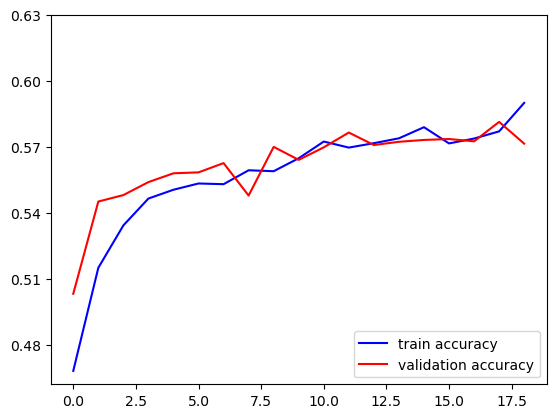

In [188]:
import matplotlib.pyplot as plt
plt.plot(his.history['accuracy'],c='b',label='train accuracy')
plt.plot(his.history['val_accuracy'],c='r',label='validation accuracy')
plt.yticks(np.arange(0.48, 0.65, 0.03))
plt.legend(loc='lower right')
plt.show()

In [181]:
y_pred =   np.argmax(bilstmModel.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

149/149 [==============================] - 30s 187ms/step
              precision    recall  f1-score   support

           0       0.65      0.46      0.54      1795
           1       0.68      0.62      0.65      2417
           2       0.28      0.67      0.39       541

    accuracy                           0.56      4753
   macro avg       0.54      0.58      0.53      4753
weighted avg       0.62      0.56      0.58      4753



In [266]:
import tweepy
from pandas import Series,DataFrame
import pandas as pd

#bearer_token='AAAAAAAAAAAAAAAAAAAAAA0ujQEAAAAAypsPaQvJZvFJ5W41sSQRf0GFlqQ%3D1OR4Ud7BROkZFUzqQMtkF4ajCovlijI7bhj83XBHRF663hKNSJ'
secret = '4HseuJG9ttk4DkiALIOSMa5KUVsgp1AIDP9nNraL7T2BbYReBM'
auth = tweepy.OAuthHandler('Gfah4QwbZfQJDoxOh3ShnVVcr', secret)
api = tweepy.API(auth)
tweet_lst = []
for tweet in tweepy.Cursor(api.search_tweets, q="#BlackLivesMatter AND #sad", rpp=100, lang="en").items():
    tweet_lst.append(tweet)
    pass



data = {'content': tweet_lst}
tweet_df = DataFrame(data)

Unexpected parameter: rpp


TooManyRequests: 429 Too Many Requests
88 - Rate limit exceeded

In [260]:
tweet_df

,content,processed
0,"Wed Oct 28 2020 DC, Washington DC - Officer pe...",wed oct washington officer pepper sprays journ...
1,https://t.co/sKY0fAES97\n#BlackHistoryandConne...,blackhistoryandconnections black blackexcellen...
2,Partido Liga Regular\n\n#BlackLivesMatter (6-6...,partido liga regular blacklivesmatter dubnatio...
3,"It never mattered how big you are, she’s a sno...",never mattered how big you are she snowbunny a...
4,Defund the #UniversityPlacePolice #BlackLivesM...,defund the universityplacepolice blacklivesmatter
...,...,...
95,BlackLivesMatter but the blacks keep gunning d...,blacklivesmatter but the blacks keep gunning d...
96,DING^ Ding! ding ding... ding ding &amp; Ding ...,ding ding ding ding ding ding amp ding ding pe...
97,https://t.co/6GffU8wkw1\n\n#mikesrandomthought...,mikesrandomthoughts redwave redwave joebidensa...
98,#BlackLivesMatter https://t.co/wsHjy53qgf,blacklivesmatter


In [261]:
tweet_pro = preprocess(tweet_df)

C:\Users\mangu\AppData\Local\Temp\ipykernel_9540\2613350570.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_9540\2613350570.py:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


In [244]:
tweet_pro

,content,processed
0,"Wed Oct 28 2020 DC, Washington DC - Officer pe...",wed oct washington officer pepper sprays journ...
1,https://t.co/sKY0fAES97\n#BlackHistoryandConne...,blackhistoryandconnections black blackexcellen...
2,Partido Liga Regular\n\n#BlackLivesMatter (6-6...,partido liga regular blacklivesmatter dubnatio...
3,"It never mattered how big you are, she’s a sno...",never mattered how big you are she snowbunny a...
4,Defund the #UniversityPlacePolice #BlackLivesM...,defund the universityplacepolice blacklivesmatter
...,...,...
95,BlackLivesMatter but the blacks keep gunning d...,blacklivesmatter but the blacks keep gunning d...
96,DING^ Ding! ding ding... ding ding &amp; Ding ...,ding ding ding ding ding ding amp ding ding pe...
97,https://t.co/6GffU8wkw1\n\n#mikesrandomthought...,mikesrandomthoughts redwave redwave joebidensa...
98,#BlackLivesMatter https://t.co/wsHjy53qgf,blacklivesmatter


In [245]:
tweet_x = tweet_pro['processed']
tokenizer.fit_on_texts(tweet_x)
seq = tokenizer.texts_to_sequences(tweet_x)
X_tweet = pad_sequences(seq, maxlen = 34, padding='post')
y_test = to_categorical(y_test)
y_pred =   np.argmax(bilstmModel.predict(X_tweet), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_pred, y_true))

4/4 [==============================] - 4s 271ms/step


ValueError: Found input variables with inconsistent numbers of samples: [100, 4753]